<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Введение в анализ данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Семинар 12. Случайный лес и бустинг

## Кривые валидации и обучения для Xgboost и набора данных Titanic

**Подключаем библиотеки.**

In [4]:
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve, learning_curve
from sklearn.metrics import accuracy_score
import sys
# path to load_titanic_with_features
sys.path.append('../../scripts')
from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


**Считываем данные (можно использовать и свою функцию для загрузки данных Titanic и извлечения признаков) и выделяем части для подбора параметров и финальной проверки модели**

In [2]:
X_train, y, X_test, = map(np.array, 
                          load_titanic("../../data/titanic_train.csv",
                                   "../../data/titanic_test.csv"))
X_valid, X_holdout, y_valid, y_holdout = train_test_split(X_train, y, 
                                                          train_size=0.8, 
                                                          random_state=13)

**Напишем функцию для вывода результатов в виде, готовом для посылки на Kaggle.**

In [3]:
def write_to_file(predicted_labels, filename, init_index=892):
    predicted_df = pd.DataFrame(predicted_labels,
                index = np.arange(init_index, 
                                  init_index + \
                                  X_test.shape[0]),
                columns=["Survived"])
    predicted_df.to_csv(filename, 
                        index_label="PassengerId")

**Построим кривые валидации и обучения.**

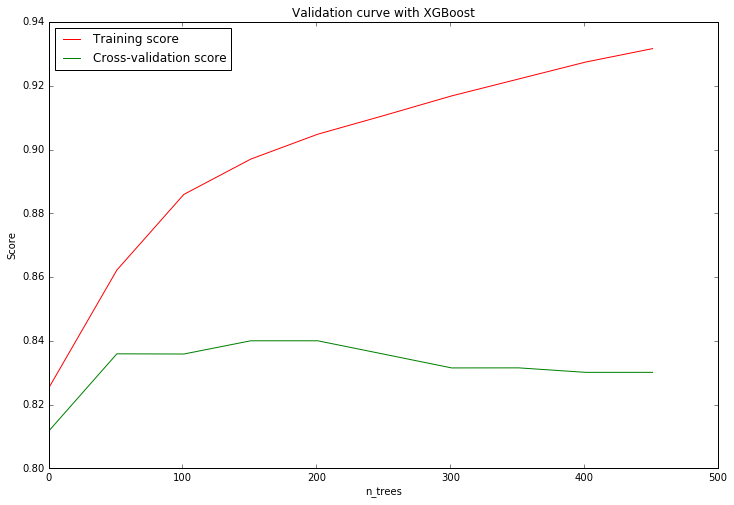

In [7]:
n_trees = np.arange(1, 501, 50)
train_scores, valid_scores = validation_curve(xgb.XGBClassifier(max_depth=3, 
    learning_rate=0.1), X_valid, y_valid, "n_estimators", n_trees, cv=10)

plot(n_trees, np.mean(train_scores, axis=1), 
           label="Training score", color="r")
plot(n_trees, np.mean(valid_scores, axis=1), 
           label="Cross-validation score", color="g")
title("Validation curve with XGBoost")
xlabel("n_trees")
ylabel("Score")
legend(loc="best")
show()

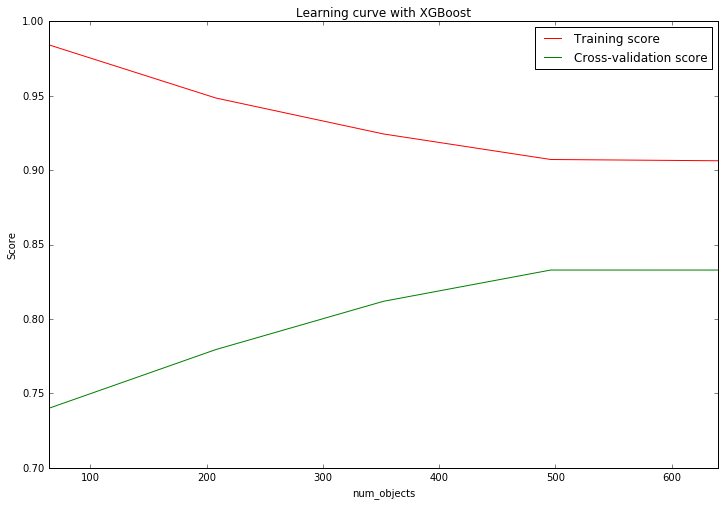

In [8]:
train_sizes, train_scores, valid_scores = learning_curve(xgb.XGBClassifier(
        max_depth=3, learning_rate=0.1, n_estimators=200), X_valid, y_valid, cv=10)

plot(train_sizes, np.mean(train_scores, axis=1), 
           label="Training score", color="r")
plot(train_sizes, np.mean(valid_scores, axis=1), 
           label="Cross-validation score", color="g")
title("Learning curve with XGBoost")
xlim((np.min(train_sizes), np.max(train_sizes)))
xlabel("num_objects")
ylabel("Score")
legend(loc="best")
show()

**Учитывая построенные выше графики, выберите наилучшие значения параметров и обучите модель XGBoost на X_valid**

По кривой валидации видно, что максимальное значение score при кросс-валидации достигается при n_estimators = 200. Поэтому будем обучать модель именно с этим значением этого параметра. Также из кривой обучения видно, что зелёная кривая продолжает расти при увеличении объёма выборки, поэтому после проверки модели на hold-out выборке, итоговую модель будем обучать, используя обучающую выборку целиком.

In [9]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=200, 
                        learning_rate=0.1).fit(X_valid, y_valid)

**Проверим модель на X_holdout.**

In [10]:
print("Hold-out accuracy = " + 
      str(round(accuracy_score(y_holdout, gbm.predict(X_holdout)), 3)))

gbm_fin = xgb.XGBClassifier(max_depth=3, n_estimators=200, 
                            learning_rate=0.1).fit(X_train, y)
write_to_file(gbm_fin.predict(X_test), "../../output/titanic_submission.csv")

Hold-out accuracy = 0.844
